<a href="https://colab.research.google.com/github/olatunbosunoyeleke94/lagos-no2-population-exposure/blob/main/Lagos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# 🛰️ Import libraries
import ee
import geemap

# 🌐 Authenticate & initialize Earth Engine with your GEE project ID
ee.Authenticate()
ee.Initialize(project='urban-expansion-study-2025')  # ⬅️ Replace with your actual GEE project ID

# 📍 Define Lagos boundary using FAO GAUL
lagos = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Lagos')) \
    .geometry()

# 🛰️ Load Sentinel-5P NO2 dataset (Jan 2019)
no2_dataset = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
    .select('NO2_column_number_density') \
    .filterDate('2019-01-01', '2025-06-12') \
    .filterBounds(lagos)

# 📊 Compute monthly median and clip to Lagos
no2_median = no2_dataset.median().clip(lagos)

# 🎨 Visualization parameters
vis_params = {
    'min': 0,
    'max': 0.0002,
    'palette': ['black', 'purple', 'blue', 'green', 'yellow', 'red']
}

# 🗺️ Create map and add layers
Map = geemap.Map(center=[6.5244, 3.3792], zoom=9)
Map.addLayer(no2_median, vis_params, "NO₂ - Jan 2019 - June 2025")
Map.addLayer(lagos, {}, "Lagos Boundary")
Map


Map(center=[6.5244, 3.3792], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

TraitError: The 'value' trait of a Label instance expected a unicode string, not the bool False.

🟢 Animated NO₂ GIF: https://earthengine.googleapis.com/v1/projects/urban-expansion-study-2025/videoThumbnails/273667c95894ecefc4bf36d5091823d9-02f06f805710b4e9a42f651b7bf8bd93:getPixels


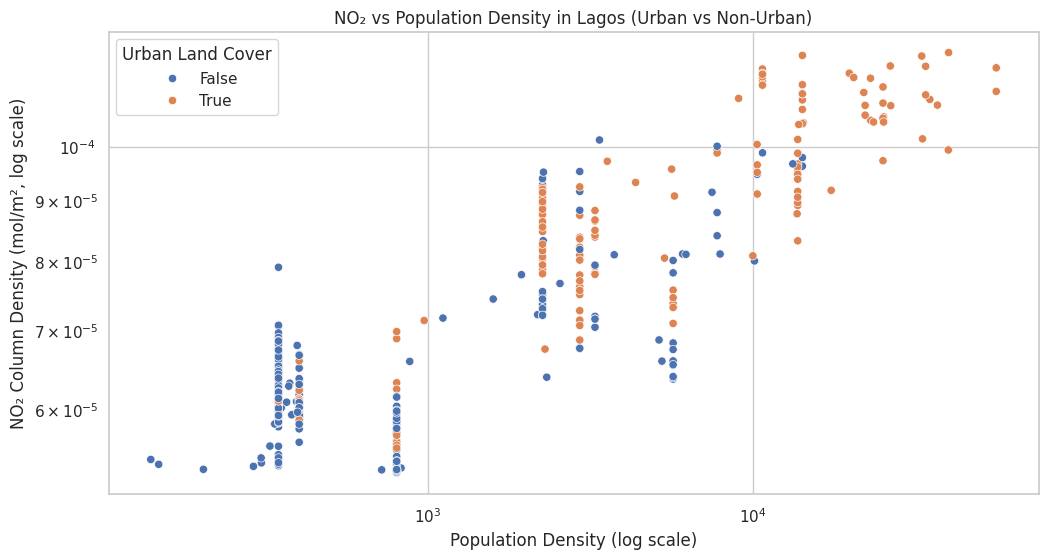

In [6]:
import ee
import geemap
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# 🌍 Authenticate & initialize (use your GEE project)
ee.Authenticate()
ee.Initialize(project='urban-expansion-study-2025')  # ✅ Replace with your Earth Engine project ID

# 📍 Get Lagos boundary
lagos = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Lagos')) \
    .geometry()

# 🛰️ Load Sentinel-5P NO₂ dataset
no2_collection = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
    .select('NO2_column_number_density') \
    .filterBounds(lagos) \
    .filterDate('2019-01-01', '2024-01-01')

# ⏳ Generate monthly median images
def get_monthly_image(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    img = no2_collection.filterDate(start, end).median().clip(lagos)
    return img.set({'system:time_start': start.millis()})

dates = [(y, m) for y in range(2019, 2024) for m in range(1, 13)]
monthly_images = [get_monthly_image(y, m) for y, m in dates]
no2_monthly = ee.ImageCollection(monthly_images)

# 🎨 Visualization settings
vis = {
    'min': 0,
    'max': 0.0002,
    'palette': ['black', 'purple', 'blue', 'green', 'yellow', 'red']
}

# 🎞️ Create and print animated NO₂ GIF
gif_config = {
    'region': lagos,
    'dimensions': 600,
    'framesPerSecond': 3,
    'format': 'gif',
    'palette': vis['palette'],
    'min': vis['min'],
    'max': vis['max']
}

gif_url = no2_monthly.getVideoThumbURL(gif_config)
print("🟢 Animated NO₂ GIF:", gif_url)

# --- 🔍 CORRELATION ANALYSIS ---

# 🧍‍♂️ Load the correct 2020 population image
pop = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density") \
    .filter(ee.Filter.eq('system:index', 'gpw_v4_population_density_rev11_2020_30_sec')) \
    .first() \
    .clip(lagos)


# 🏙️ Load MODIS land cover and create urban mask (class 13)
modis = ee.Image("MODIS/006/MCD12Q1/2020_01_01").select('LC_Type1').clip(lagos)
urban_mask = modis.eq(13)

# 📊 Compute average NO₂ for the entire period
no2_mean = no2_collection.mean().clip(lagos)

# 📍 Generate random sample points over Lagos
points = ee.FeatureCollection.randomPoints(region=lagos, points=500, seed=42)

# 🔄 Sample NO₂, population, and urban mask at points
sampled = no2_mean.addBands(pop).addBands(urban_mask).sampleRegions(
    collection=points,
    scale=1000,
    geometries=True
)

# ⬇️ Convert Earth Engine FeatureCollection to pandas DataFrame
df = geemap.ee_to_df(sampled)

# 🧼 Clean and rename columns
df = df.rename(columns={
    'NO2_column_number_density': 'NO2',
    'population_density': 'Population',
    'LC_Type1': 'Urban'
})
df['Urban'] = df['Urban'].astype(bool)

# 📈 Plot correlation between NO₂, Population, and Urban land
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Population', y='NO2', hue='Urban')
plt.title('NO₂ vs Population Density in Lagos (Urban vs Non-Urban)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population Density (log scale)')
plt.ylabel('NO₂ Column Density (mol/m², log scale)')
plt.legend(title="Urban Land Cover")
plt.show()


In [7]:
# List all image indexes in the GPW population dataset
pop_collection = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density")
indexes = pop_collection.aggregate_array("system:index").getInfo()
print("Available population data years:", indexes)


Available population data years: ['gpw_v4_population_density_rev11_2000_30_sec', 'gpw_v4_population_density_rev11_2005_30_sec', 'gpw_v4_population_density_rev11_2010_30_sec', 'gpw_v4_population_density_rev11_2015_30_sec', 'gpw_v4_population_density_rev11_2020_30_sec']


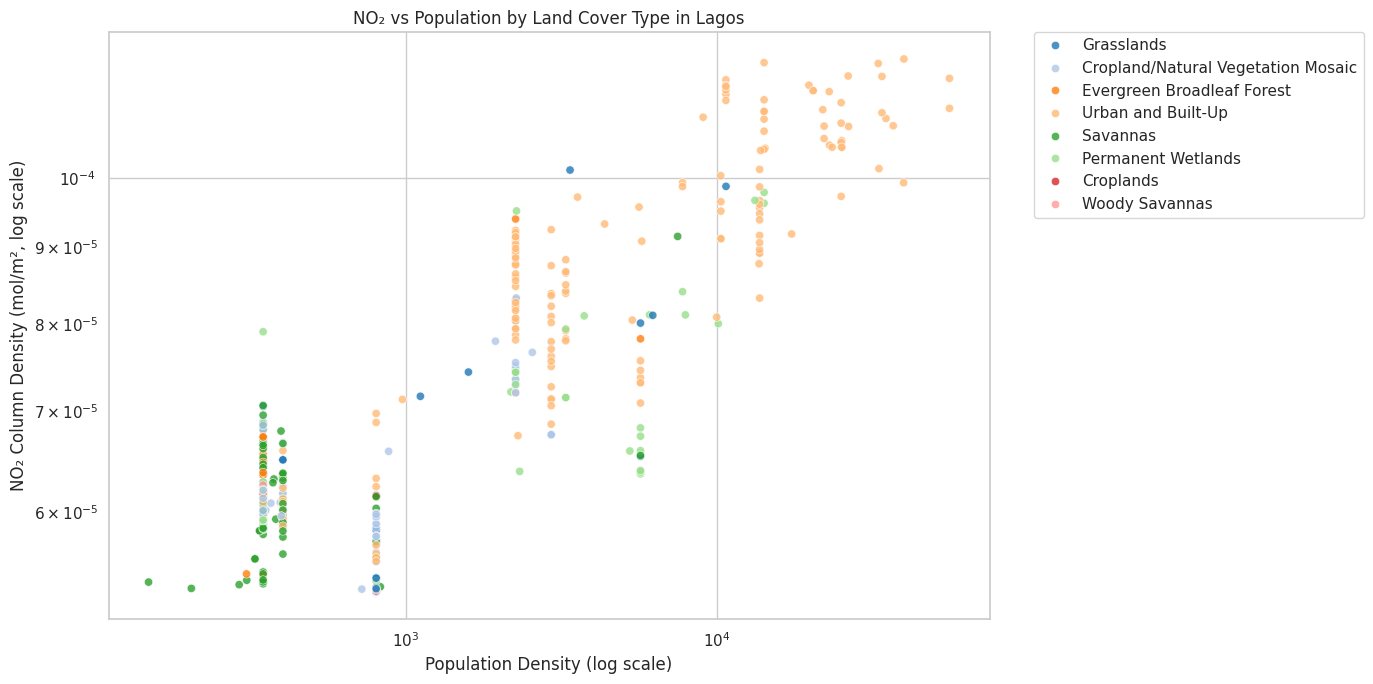

In [8]:
# ✅ Load MODIS Land Cover full class labels
modis = ee.Image("MODIS/006/MCD12Q1/2020_01_01").select('LC_Type1').clip(lagos)

# 🧍‍♂️ Population (confirmed fix)
pop = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density") \
    .filter(ee.Filter.eq('system:index', 'gpw_v4_population_density_rev11_2020_30_sec')) \
    .first() \
    .clip(lagos)

# 📊 NO₂ mean over 6 years
no2_mean = no2_collection.mean().clip(lagos)

# 📍 Generate sample points
points = ee.FeatureCollection.randomPoints(region=lagos, points=500, seed=42)

# 🧪 Sample all 3 variables
sampled = no2_mean.addBands(pop).addBands(modis).sampleRegions(
    collection=points,
    scale=1000,
    geometries=True
)

# ⬇️ Convert to pandas
df = geemap.ee_to_df(sampled)

# 📖 Rename columns (✅ fixed)
df = df.rename(columns={
    'NO2_column_number_density': 'NO2',
    'LC_Type1': 'LandCover',
    'population_density': 'Population'  # ✅ Corrected key
})

# 📊 MODIS Land Cover class map
modis_classes = {
    0: 'Water',
    1: 'Evergreen Needleleaf Forest',
    2: 'Evergreen Broadleaf Forest',
    3: 'Deciduous Needleleaf Forest',
    4: 'Deciduous Broadleaf Forest',
    5: 'Mixed Forests',
    6: 'Closed Shrublands',
    7: 'Open Shrublands',
    8: 'Woody Savannas',
    9: 'Savannas',
    10: 'Grasslands',
    11: 'Permanent Wetlands',
    12: 'Croplands',
    13: 'Urban and Built-Up',
    14: 'Cropland/Natural Vegetation Mosaic',
    15: 'Snow and Ice',
    16: 'Barren or Sparsely Vegetated'
}

# Map numeric land cover codes to descriptive labels
df['LandCoverClass'] = df['LandCover'].map(modis_classes)

# 📉 Plot with all land cover classes
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df, x='Population', y='NO2', hue='LandCoverClass', palette='tab20', alpha=0.8)
plt.title('NO₂ vs Population by Land Cover Type in Lagos')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population Density (log scale)')
plt.ylabel('NO₂ Column Density (mol/m², log scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

# ✅ Save plot locally
plt.savefig("NO2_vs_Population_by_LandCover.png", dpi=300)
plt.savefig("NO2_vs_Population_by_LandCover.pdf")
plt.show()

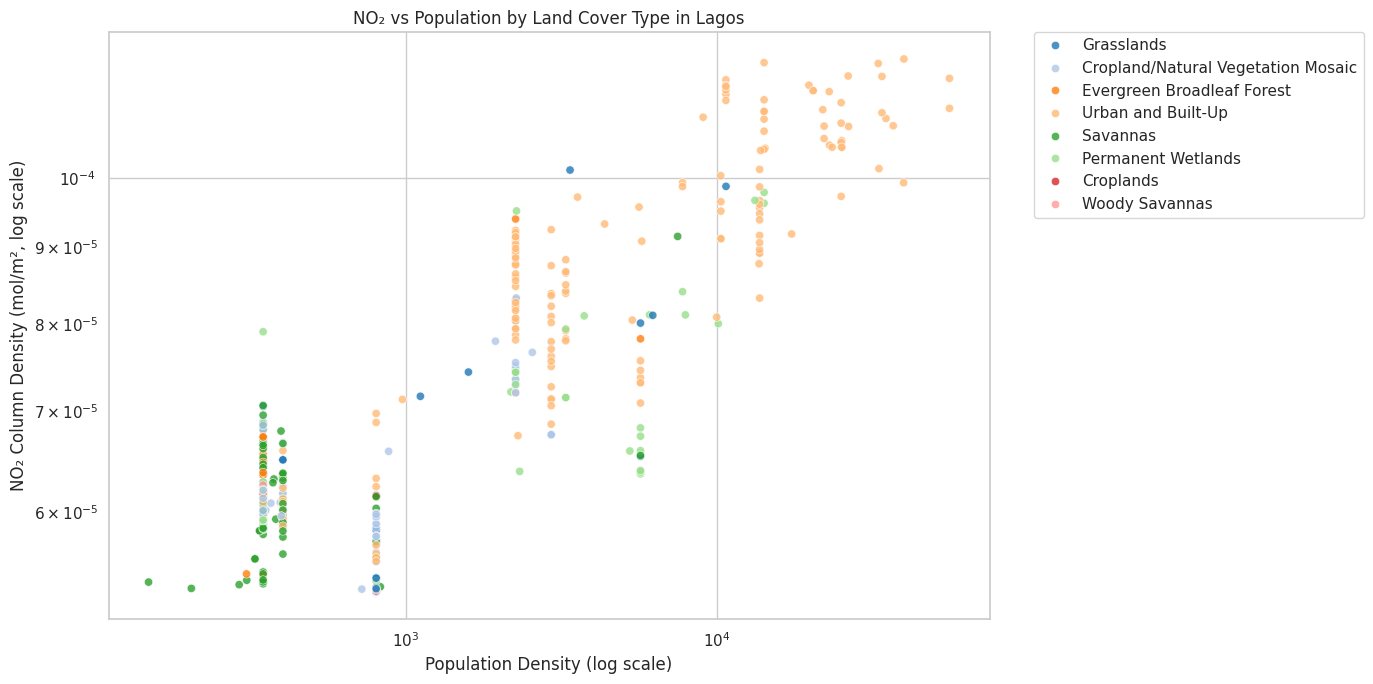

In [9]:
# ✅ Load MODIS Land Cover full class labels
modis = ee.Image("MODIS/006/MCD12Q1/2020_01_01").select('LC_Type1').clip(lagos)

# 🧍‍♂️ Population (confirmed fix)
pop = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density") \
    .filter(ee.Filter.eq('system:index', 'gpw_v4_population_density_rev11_2020_30_sec')) \
    .first() \
    .clip(lagos)

# 📊 NO₂ mean over 6 years
no2_mean = no2_collection.mean().clip(lagos)

# 📍 Generate sample points
points = ee.FeatureCollection.randomPoints(region=lagos, points=500, seed=42)

# 🧪 Sample all 3 variables
sampled = no2_mean.addBands(pop).addBands(modis).sampleRegions(
    collection=points,
    scale=1000,
    geometries=True
)

# ⬇️ Convert to pandas
df = geemap.ee_to_df(sampled)

# 📖 Rename columns
df = df.rename(columns={
    'NO2_column_number_density': 'NO2',
    'LC_Type1': 'LandCover',
    'gpw_v4_population_density_rev11_2020_30_sec': 'population_density'
})

# 📊 MODIS Land Cover class map
modis_classes = {
    0: 'Water',
    1: 'Evergreen Needleleaf Forest',
    2: 'Evergreen Broadleaf Forest',
    3: 'Deciduous Needleleaf Forest',
    4: 'Deciduous Broadleaf Forest',
    5: 'Mixed Forests',
    6: 'Closed Shrublands',
    7: 'Open Shrublands',
    8: 'Woody Savannas',
    9: 'Savannas',
    10: 'Grasslands',
    11: 'Permanent Wetlands',
    12: 'Croplands',
    13: 'Urban and Built-Up',
    14: 'Cropland/Natural Vegetation Mosaic',
    15: 'Snow and Ice',
    16: 'Barren or Sparsely Vegetated'
}

df['LandCoverClass'] = df['LandCover'].map(modis_classes)

# 📉 Plot with all land cover classes
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df, x='population_density', y='NO2', hue='LandCoverClass', palette='tab20', alpha=0.8)
plt.title('NO₂ vs Population by Land Cover Type in Lagos')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population Density (log scale)')
plt.ylabel('NO₂ Column Density (mol/m², log scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

# ✅ Save plot locally
plt.savefig("NO2_vs_Population_by_LandCover.png", dpi=300)
plt.savefig("NO2_vs_Population_by_LandCover.pdf")
plt.show()


In [ ]:
print(df.columns)

Index(['LandCover', 'NO2', 'population_density', 'LandCoverClass'], dtype='object')


In [ ]:
print(df.shape)
print(df.head())
print(df.columns.tolist())
type(df)

(500, 4)
   LandCover       NO2  population_density                      LandCoverClass
0         10  0.000065          402.324890                          Grasslands
1         17  0.000085            0.000000                                 NaN
2         14  0.000056          802.438354  Cropland/Natural Vegetation Mosaic
3          2  0.000066          347.502197          Evergreen Broadleaf Forest
4         13  0.000096        13723.451172                  Urban and Built-Up
['LandCover', 'NO2', 'population_density', 'LandCoverClass']


pandas.core.frame.DataFrame

In [4]:
import ee
import geemap
import seaborn as sns
import matplotlib.pyplot as plt

# 🌐 Authenticate & initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='urban-expansion-study-2025')

# 📍 Define Lagos boundary
lagos = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Lagos')) \
    .geometry()

# 🛰️ NO₂ mean 2019–2025
no2_collection = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
    .select('NO2_column_number_density') \
    .filterBounds(lagos) \
    .filterDate('2019-01-01', '2025-06-12')
no2_mean = no2_collection.mean().clip(lagos)

# 🔥 MODIS LST (6 years average in °C)
lst = ee.ImageCollection("MODIS/061/MOD11A2") \
    .select("LST_Day_1km") \
    .filterBounds(lagos) \
    .filterDate('2019-01-01', '2025-06-12') \
    .mean() \
    .clip(lagos) \
    .multiply(0.02).subtract(273.15)

# 🛰️ Sentinel-2 RGB composite
sentinel = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(lagos) \
    .filterDate("2019-01-01", "2025-06-12") \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median() \
    .clip(lagos)

# 🏭 Sentinel-5P CO mean 2019 - 2025
co = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CO") \
    .select('CO_column_number_density') \
    .filterDate('2019-01-01', '2025-06-12') \
    .filterBounds(lagos) \
    .mean() \
    .clip(lagos)

# 🎨 Visualization parameters
no2_vis = {'min': 0, 'max': 0.0002, 'palette': ['black', 'purple', 'blue', 'green', 'yellow', 'red']}
lst_vis = {'min': 20, 'max': 45, 'palette': ['blue', 'green', 'yellow', 'orange', 'red']}
rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
co_vis = {'min': 0, 'max': 0.05, 'palette': ['blue', 'green', 'yellow', 'orange', 'red']}

# 🗺️ Create interactive map with Google Earth satellite basemap
Map = geemap.Map(center=[6.5, 3.3], zoom=9, basemap='SATELLITE')  # Use Google Earth satellite imagery
Map.addLayer(no2_mean, no2_vis, "NO₂ Mean (2019–2025)")
Map.addLayer(lst, lst_vis, "LST (MODIS, 6 years °C)")
Map.addLayer(sentinel, rgb_vis, "Sentinel-2 RGB (6 years)")
Map.addLayer(co, co_vis, "CO Mean (6 years)")
Map.addLayer(lagos, {}, "Lagos Boundary")
Map

Map(center=[6.5, 3.3], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…